In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch
from util.data_utilities import process_data

In [2]:
# Current Path
os.getcwd()

'/home/louis/Documents/gatech/Summer2023/Multimodal-Deep-Regression/notebooks'

In [3]:
device = get_device()
x_dir, y_dir = get_base_tensor_directories(input_type='video_pack_1000')

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

You are using device: cuda


In [4]:
# load all tensors
x_data = [torch.load(f) for f in x_files]
y_data = [torch.load(f) for f in y_files]

# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 3, 128, 72])
torch.Size([3, 2, 128, 72])
16
4


In [5]:
# Create Batches with DataLoaders
batch_size = 1
train_loader = list(zip(x_train, x_train)) #TensorDataset(x_train, y_train)
val_loader = list(zip(x_val, x_val)) #TensorDataset(x_val, y_val)
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)

data, targets = next(iter(train_loader))
data.size(), targets.size()

(torch.Size([1, 3, 5, 128, 72]), torch.Size([1, 3, 5, 128, 72]))

In [6]:
# This need to same as the main & preprocess
frames_to_skip=200 # how many frame to skip, reduce depth
shrink=8 # shrink H x W, the higher the smaller scale
normalize=False # normalize the pixel to 0 to 1

In [7]:
from models import ConvLSTMAutoencoder
model = ConvLSTMAutoencoder(hidden_dim=256, shrink=shrink, normalize=normalize)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=1e-4)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 3

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

Total parameters: 16,553,731
First epoch took 3.0 minutes.
Epoch 1/3, Train_Loss: 115767.52, Avg: 7235.47; Val_Loss: 33599.01, Avg: 8399.75
Epoch 2/3, Train_Loss: 92061.54, Avg: 5753.85; Val_Loss: 38574.53, Avg: 9643.63
Epoch 3/3, Train_Loss: 83069.28, Avg: 5191.83; Val_Loss: 32096.45, Avg: 8024.11


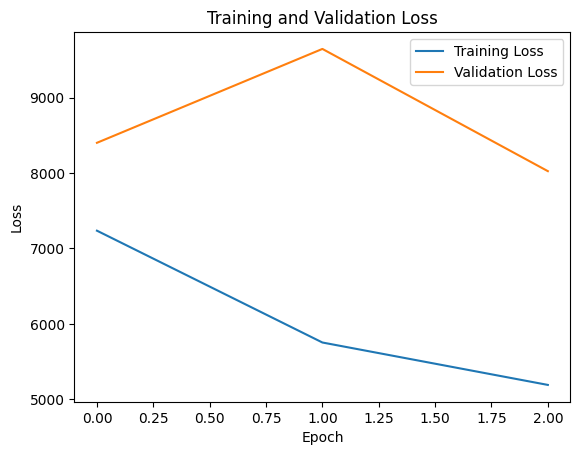

In [8]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
check = 4
i = 0
for inputs, targets in val_loader:
    i += 1
    if i == check:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        outputs = model(inputs)
        break
outputs.squeeze()[:,1,:,:]

tensor([[[109.4267,  91.3194,  91.3751,  ...,  92.1130,  93.6047, 100.1659],
         [118.4612, 104.2379, 104.6673,  ..., 104.8621, 104.5038, 101.4808],
         [118.2811, 104.6777, 105.2045,  ..., 105.1744, 104.9868, 100.8515],
         ...,
         [118.5991, 105.6007, 105.6912,  ..., 105.5759, 105.3464, 100.1439],
         [117.9057, 105.0238, 105.0012,  ..., 104.8960, 104.6156,  99.3101],
         [127.9024, 127.3367, 127.5242,  ..., 127.2747, 127.0612, 114.6367]],

        [[107.9227,  84.9618,  83.5952,  ...,  84.1862,  85.7231, 100.8400],
         [ 88.9904,  60.9762,  59.6686,  ...,  60.6544,  63.3180,  92.3443],
         [ 88.4291,  60.2047,  59.0145,  ...,  59.4751,  60.9763,  91.7092],
         ...,
         [ 87.5873,  59.3241,  58.5731,  ...,  58.6502,  59.1815,  90.7734],
         [ 87.0873,  59.4727,  58.3873,  ...,  58.4856,  59.3712,  90.3953],
         [ 93.6208,  72.9399,  72.0092,  ...,  72.0274,  72.9365,  98.0337]],

        [[ 98.0189,  71.4827,  69.8187,  ...

In [22]:
outputs.squeeze().size()

torch.Size([3, 36, 128, 72])

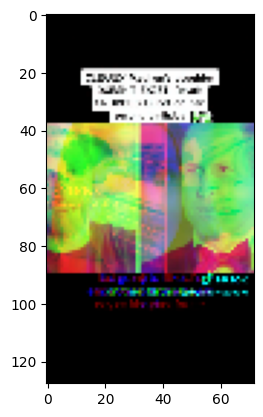

In [23]:
import torch
import matplotlib.pyplot as plt

# select a frame
image_tensor = targets.squeeze()[:,1,:,:]
numpy_image = image_tensor.detach().numpy()

# imshow (Height, Width, Channels)
numpy_image = numpy_image.transpose((1, 2, 0))

# normalize to 0,1
numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

plt.imshow(numpy_image)
plt.show()

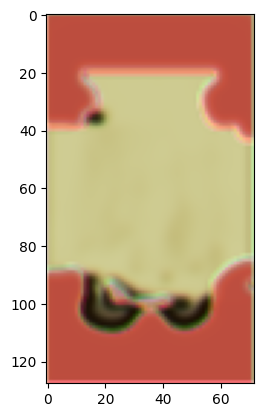

In [24]:
import torch
import matplotlib.pyplot as plt

# select a frame
image_tensor = outputs.squeeze()[:,1,:,:]
numpy_image = image_tensor.detach().numpy()

# imshow (Height, Width, Channels)
numpy_image = numpy_image.transpose((1, 2, 0))

# normalize to 0,1
numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

plt.imshow(numpy_image)
plt.show()